# Simple Stock Price Prediction Model

Created by Marc Zeugin

### Import modules

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import yfinance as yf
import pandas as pd
import numpy as np
import math
import os

### Set tickers

In [2]:
tickers = ['AAL', 'AAPL', 'AAP', 'MSFT']

### Set options

In [3]:
period = '5y'
training_data_split = 0.8

### Load financial data from yahoo finance API or local folder if available

In [4]:
ticker_hist_list = []

for ticker in tickers:
    path = './data/' + ticker + '_data.json'
    if os.path.exists(path=path):
        with open(path) as f:
            temp_ticker_hist = pd.read_json(path)
        ticker_hist_list.append(temp_ticker_hist)
    else:
        temp_ticker = yf.Ticker(ticker=ticker)
        temp_ticker_hist = temp_ticker.history(period=period)
        ticker_hist_list.append(temp_ticker_hist)

In [5]:
print(len(ticker_hist_list))

4


### Save data to local folder

In [6]:
for i in range(len(ticker_hist_list)):
    ticker_hist_list[i].to_json('./data/' + tickers[i] + '_data.json')

### Display some data properties

In [7]:
for i in range(len(ticker_hist_list)):
    # print(ticker_hist_list[i].head(5))
    print(ticker_hist_list[i].info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1260 entries, 2017-06-05 to 2022-06-03
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1260 non-null   float64
 1   High          1260 non-null   float64
 2   Low           1260 non-null   float64
 3   Close         1260 non-null   float64
 4   Volume        1260 non-null   int64  
 5   Dividends     1260 non-null   float64
 6   Stock Splits  1260 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 111.0 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1260 entries, 2017-06-05 to 2022-06-03
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1260 non-null   float64
 1   High          1260 non-null   float64
 2   Low           1260 non-null   float64
 3   Close         1260 non-null   float64
 4   Volume        1260 non-null   int64  
 5   Di

### Display all stocks plots

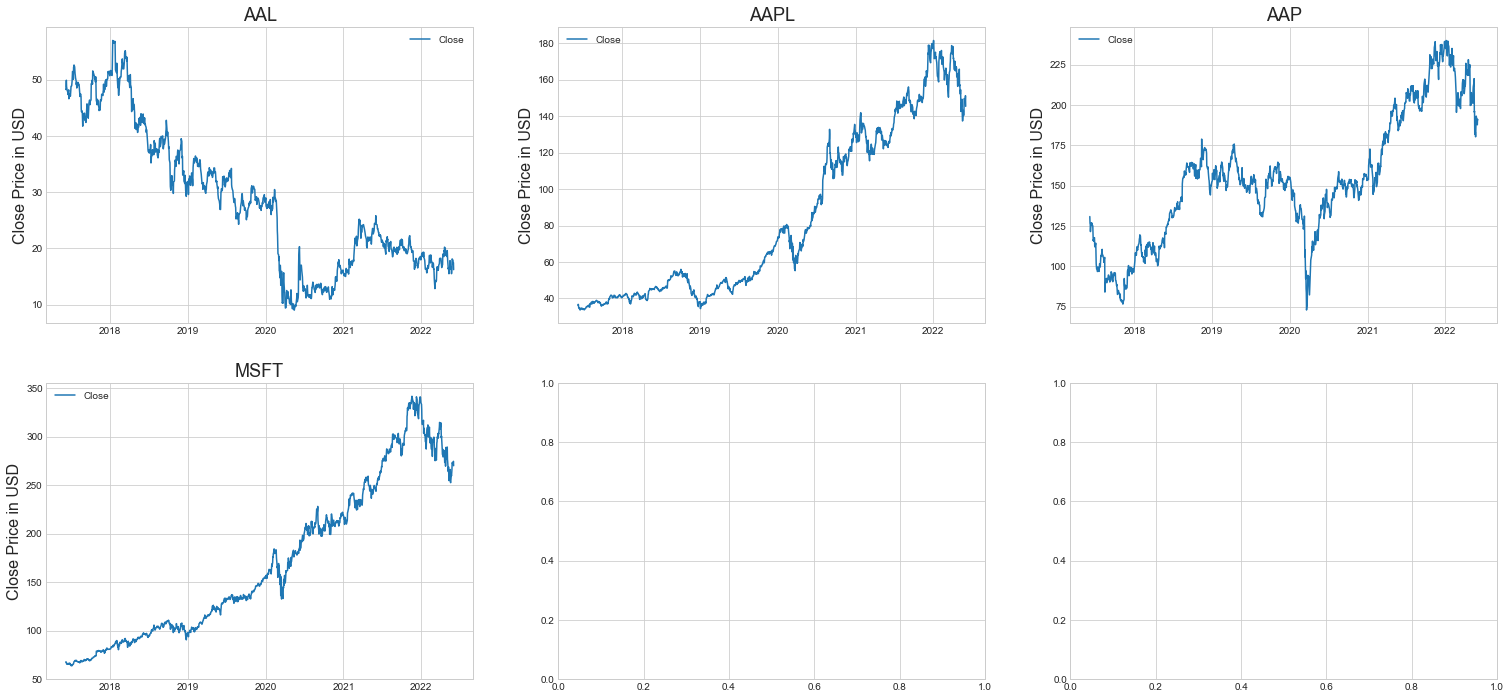

In [8]:
rows = int(math.ceil(len(tickers)/3))
cols = 3

fig, ax = plt.subplots(rows, cols, figsize=(26, 6*rows))

if rows == 1:
    for col in range(cols):
        ax[col].set_title(tickers[col], fontsize=18)
        ax[col].plot(ticker_hist_list[col]['Close'], label='Close')
        ax[col].legend(loc='best')
        ax[col].set_ylabel('Close Price in USD', fontsize=16)
else:
    for row in range(rows):
        for col in range(cols):
            if col + 3*row < len(tickers):
                ax[row, col].set_title(tickers[col + 3*row], fontsize=18)
                ax[row, col].plot(ticker_hist_list[col + 3*row]['Close'], label='Close')
                ax[row, col].legend(loc='best')
                ax[row, col].set_ylabel('Close Price in USD', fontsize=16)
plt.show()

### Apply MinMaxScaler to dataset

In [9]:
close_data = ticker_hist_list[2].filter(['Close'])
dataset = close_data.values
training_data_len = math.ceil(len(ticker_hist_list[2])*training_data_split)

scaler = MinMaxScaler()
scaled_dataset = scaler.fit_transform(np.array(dataset).reshape(-1,1))

print(scaled_dataset.shape)

(1260, 1)


### Split into training and testing data & reshape input for LSTM model to match requirements

In [10]:
step = 60

#Creating the scaled training data set
train_data = scaled_dataset[0:training_data_len, : ]
#Spliting the data into x_train and y_train data sets
X_train = []
y_train = []
for i in range(step, len(train_data)):
    X_train.append(train_data[i-step:i, 0])
    y_train.append(train_data[i, 0])
    
#Here we are Converting x_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Here we are reshaping the data into the shape accepted by the LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# here we are testing data set
test_data = scaled_dataset[training_data_len-step: , : ]
#Creating the X_test and y_test data sets
X_test = []
y_test =  dataset[training_data_len: , : ]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    
# here we are converting x_test to a numpy array  
X_test = np.array(X_test)

# here we are reshaping the data into the shape accepted by the LSTM  
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Setup the LSTM model

In [11]:
model = Sequential()
model.add(LSTM(16, return_sequences=True, input_shape=(step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(16, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16))
model.add(Dense(16))
model.add(Dense(1, activation='linear'))
model.compile(loss="mean_squared_error" , optimizer="adam")

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 16)            1152      
                                                                 
 dropout (Dropout)           (None, 60, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 16)            2112      
                                                                 
 dropout_1 (Dropout)         (None, 60, 16)            0         
                                                                 
 lstm_2 (LSTM)               (None, 16)                2112      
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 1

### Fit LSTM model

In [13]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
15/15 [==============================] - 5s 105ms/step - loss: 0.0514 - val_loss: 45402.0938
Epoch 2/100
15/15 [==============================] - 1s 42ms/step - loss: 0.0117 - val_loss: 45491.1055
Epoch 3/100
15/15 [==============================] - 1s 39ms/step - loss: 0.0078 - val_loss: 45441.7383
Epoch 4/100
15/15 [==============================] - 1s 44ms/step - loss: 0.0054 - val_loss: 45430.8203
Epoch 5/100
15/15 [==============================] - 1s 41ms/step - loss: 0.0041 - val_loss: 45412.6055
Epoch 6/100
15/15 [==============================] - 1s 41ms/step - loss: 0.0033 - val_loss: 45400.8789
Epoch 7/100
15/15 [==============================] - 1s 44ms/step - loss: 0.0034 - val_loss: 45391.6445
Epoch 8/100
15/15 [==============================] - 1s 40ms/step - loss: 0.0033 - val_loss: 45395.3281
Epoch 9/100
15/15 [==============================] - 1s 42ms/step - loss: 0.0032 - val_loss: 45392.5703
Epoch 10/100
15/15 [==============================] - 1s 42ms/s

dict_keys(['loss', 'val_loss'])


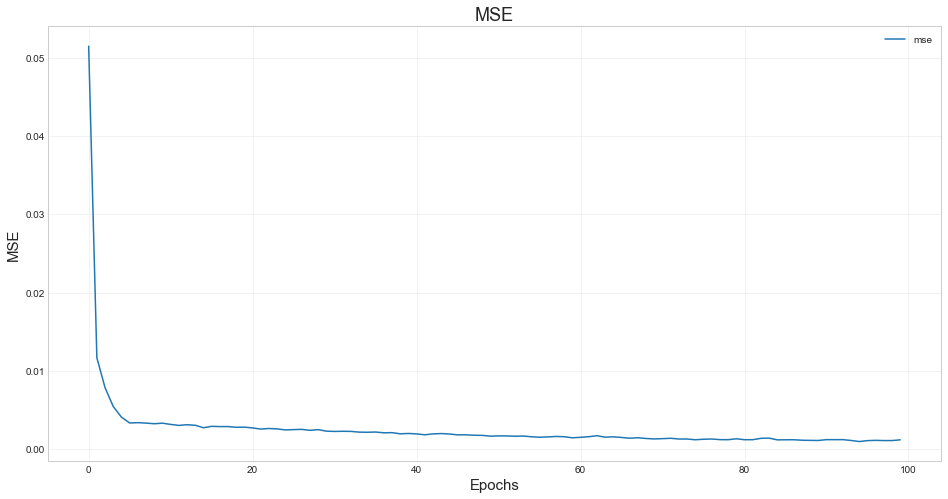

In [14]:
print(history.history.keys())
plt.figure(figsize=(16, 8))

# Accuracy
plt.plot(history.epoch, history.history['loss'], label = "mse")

plt.title("MSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("MSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

### Create predictions

In [15]:
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)

8/8 [==============================] - 1s 13ms/step


### Calculate RMSE and MAE

In [16]:
print(math.sqrt(mean_squared_error(y_test, test_predict)))
print(mean_absolute_error(y_test, test_predict))

8.614238304538175
7.199388776507744


### Plot prediction vs actual close price

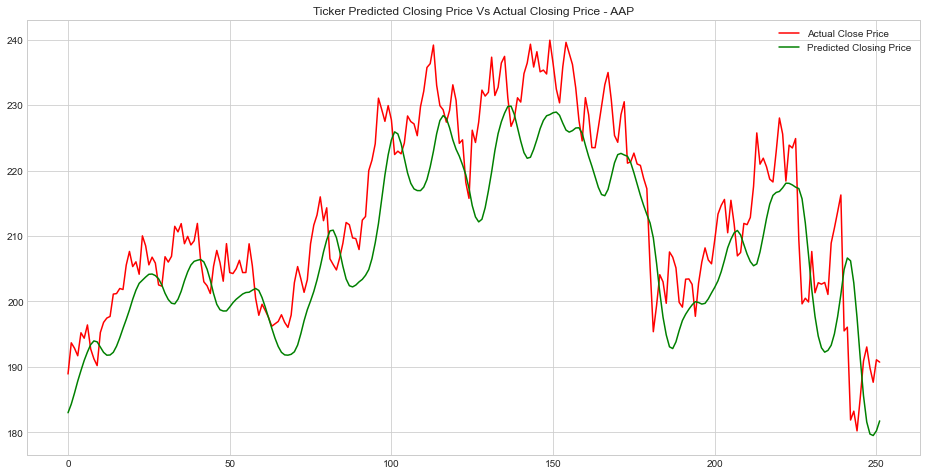

In [17]:
plt.figure(figsize=(16, 8))
plt.title(f'Ticker Predicted Closing Price Vs Actual Closing Price - {tickers[2]}')
plt.plot(y_test, color='red', label='Actual Close Price')
plt.plot(test_predict, color='green', label='Predicted Closing Price')
plt.legend(loc='best')
plt.show()

### Prediction with Logistic Regression

In [18]:
dataset_all = ticker_hist_list[2]

X = dataset_all.drop(['Close'], axis=1)
y = dataset_all['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=training_data_split, shuffle=False)

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)
pred_df_lr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_lr})
pred_df_lr.head()

,Actual,Predicted
2021-06-07,188.923996,189.025601
2021-06-08,193.681091,193.307267
2021-06-09,192.858887,193.017789
2021-06-10,191.703888,191.275941
2021-06-11,195.217896,195.216517


In [19]:
print(f'Accuracy score of the predictions: {r2_score(y_test, y_pred_lr)}')
print(f'RMSE score of the predictions: {math.sqrt(mean_squared_error(y_test, y_pred_lr))}')

Accuracy score of the predictions: 0.990112573500072
RMSE score of the predictions: 1.3936044187748087


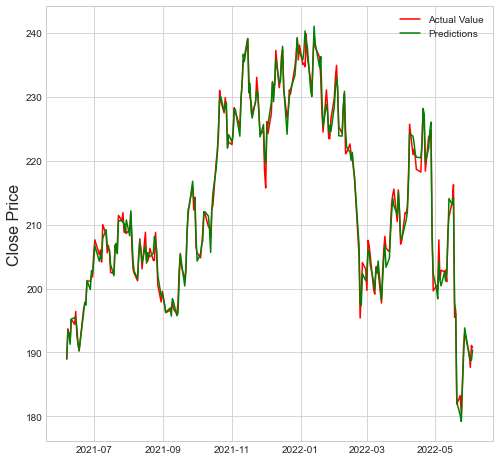

In [20]:
plt.figure(figsize=(8,8))
plt.plot(pred_df_lr['Actual'], color='red')
plt.plot(pred_df_lr['Predicted'], color='green')
plt.ylabel('Close Price', fontsize=16)
plt.legend(['Actual Value', 'Predictions'], loc='best')
plt.show()

### Function to predict user selected stock performance

In [24]:
def predict_performance(symbol):
    print(f'PREDICTION FOR {symbol}')

### Allow user to input a stock ticker to predict

In [25]:
def user_input():
    stock_name = input("Please enter a Stock Ticker to predict: ")
    
    if stock_name in tickers:
        path = './data/' + stock_name + '_data.json'
        with open(path) as f:
            temp_ticker_hist = pd.read_json(path)
        ticker_hist_list.append(temp_ticker_hist)
    else:
        try:
            temp_ticker = yf.Ticker(ticker=stock_name)
            temp_ticker_hist = temp_ticker.history(period=period)
            ticker_hist_list.append(temp_ticker_hist)
            tickers.append(stock_name)
                    
            ticker_hist_list[-1].to_json('./data/' + stock_name + '_data.json')
        except:
            print('Ticker not found!')
            user_input()
                
    predict_performance(stock_name)

user_input()

PREDICTION
